# Using CNN's with the Cats vs Dogs Dataset

In [1]:
import os
import shutil
import zipfile
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Getting and checking the data

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"


--2023-10-24 11:12:39--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.119.101.9, 2600:1415:2000:1a5::317f, 2600:1415:2000:195::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.119.101.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   131MB/s    in 6.3s    

2023-10-24 11:12:46 (124 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
zip_file = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
for root, dirs, files in os.walk('/tmp'):
 for dir in dirs:
    print(os.path.join(root, dir))


/tmp/PetImages
/tmp/hsperfdata_root
/tmp/v8-compile-cache-0
/tmp/conda
/tmp/yarn--1687755488161-0.8879838407104355
/tmp/yarn--1687755659204-0.9573163719512416
/tmp/yarn--1687755480762-0.013045315151684056
/tmp/yarn--1687755660332-0.006012616638098267
/tmp/yarn--1687755481914-0.6939425404263324
/tmp/yarn--1687755666484-0.773890063104473
/tmp/openmpi
/tmp/PetImages/Dog
/tmp/PetImages/Cat
/tmp/v8-compile-cache-0/10.2.154.26-node.25


In [5]:
cats_dir='/tmp/PetImages/Cat'
dogs_dir='/tmp/PetImages/Dog'
cats_files = os.listdir(cats_dir)
dogs_files = os.listdir(dogs_dir)
print(f'There are {len(cats_files)} cats images and {len(dogs_files)} dogs images.')

There are 12501 cats images and 12501 dogs images.


In [6]:
# Defina a root directory
root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Make train and validation directories
train_dogs_dir = os.path.join(root_dir, 'train/dogs')
os.makedirs(train_dogs_dir)
train_cats_dir = os.path.join(root_dir, 'train/cats')
os.makedirs(train_cats_dir)
val_dogs_dir = os.path.join(root_dir, 'val/dogs')
os.makedirs(val_dogs_dir)
val_cats_dir = os.path.join(root_dir, 'val/cats')
os.makedirs(val_cats_dir)

In [7]:
for root, dirs, files in os.walk(root_dir):
  for dir in dirs:
    print(os.path.join(root, dir))

/tmp/cats-v-dogs/train
/tmp/cats-v-dogs/val
/tmp/cats-v-dogs/train/cats
/tmp/cats-v-dogs/train/dogs
/tmp/cats-v-dogs/val/cats
/tmp/cats-v-dogs/val/dogs


## Splitting the data

In [8]:
# Split data to train data and validation data
def split_data(source_dir, train_dir, val_dir, train_size):
  files = os.listdir(source_dir)
  train_files = random.sample(files, int(len(files)*train_size))
  val_files = [f for f in files if f not in train_files]

  # Copy files
  def copy_files(file_list, s_dir, d_dir):
    for f in file_list:
      s_path = os.path.join(s_dir, f)
      d_path = os.path.join(d_dir, f)
      if os.path.getsize(s_path) != 0:
        shutil.copyfile(s_path, d_path)
      else:
        print(f'File {f} has a zero size, so ignoring')

  copy_files(train_files, source_dir, train_dir)
  copy_files(val_files, source_dir, val_dir)


In [9]:
# Empty directories in case they are not empty before copying files
def empty_dir(dir):
  if len(os.listdir(dir)) > 0:
    for file in os.scandir(dir):
      os.remove(file.path)

for dir in (train_cats_dir, val_cats_dir, train_dogs_dir, val_dogs_dir):
  empty_dir(dir)

# Split data and copy files to their respective directories
train_size = 0.9
split_data(cats_dir, train_cats_dir, val_cats_dir, train_size)
split_data(dogs_dir, train_dogs_dir, val_dogs_dir, train_size)

# Check the data split
print(f'Original dataset has {len(os.listdir(cats_dir))} images of cats and {len(os.listdir(dogs_dir))} images of dogs.')
print(f'There are {len(os.listdir(train_cats_dir))} images of cats for training and {len(os.listdir(val_cats_dir))} images of cats for validation now.')
print(f'There are {len(os.listdir(train_dogs_dir))} images of dogs for training and {len(os.listdir(val_dogs_dir))} images of dogs for validation now.')

File 666.jpg has a zero size, so ignoring
File 11702.jpg has a zero size, so ignoring
Original dataset has 12501 images of cats and 12501 images of dogs.
There are 11249 images of cats for training and 1251 images of cats for validation now.
There are 11249 images of dogs for training and 1251 images of dogs for validation now.


## Creating train and validation image data generators

In [10]:
# Get train and validation image data generators
def get_image_data_generator(dir):
  datagen = ImageDataGenerator(rescale=1/255)
  generator = datagen.flow_from_directory(
      directory=dir,
      target_size=(150,150),
      batch_size=25,
      class_mode='binary'
  )
  return generator


In [11]:
train_generator = get_image_data_generator(os.path.join(root_dir, 'train'))
val_generator = get_image_data_generator(os.path.join(root_dir, 'val'))

Found 22497 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


## Building and training a CNN

In [12]:
# Build a model
def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
      MaxPooling2D(2,2),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Flatten(),
      Dense(512, activation='relu'),
      Dense(1)
  ])
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
  return model

In [13]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15)

Epoch 1/15
324/900 [=========>....................] - ETA: 24s - loss: 0.9470 - accuracy: 0.5752

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


900/900 [==============================] - 51s 46ms/step - loss: 0.7294 - accuracy: 0.6285 - val_loss: 0.5602 - val_accuracy: 0.6953
Epoch 2/15
900/900 [==============================] - 40s 45ms/step - loss: 0.5332 - accuracy: 0.7230 - val_loss: 0.4981 - val_accuracy: 0.7613
Epoch 3/15
900/900 [==============================] - 40s 44ms/step - loss: 0.4728 - accuracy: 0.7689 - val_loss: 0.4865 - val_accuracy: 0.7557
Epoch 4/15
900/900 [==============================] - 41s 46ms/step - loss: 0.4340 - accuracy: 0.7920 - val_loss: 0.4902 - val_accuracy: 0.7725
Epoch 5/15
900/900 [==============================] - 41s 45ms/step - loss: 0.3949 - accuracy: 0.8148 - val_loss: 0.4730 - val_accuracy: 0.7813
Epoch 6/15
900/900 [==============================] - 40s 45ms/step - loss: 0.3464 - accuracy: 0.8416 - val_loss: 0.5163 - val_accuracy: 0.7585
Epoch 7/15
900/900 [==============================] - 40s 45ms/step - loss: 0.3291 - accuracy: 0.8487 - val_loss: 0.5275 - val_accuracy: 0.7565
Epo

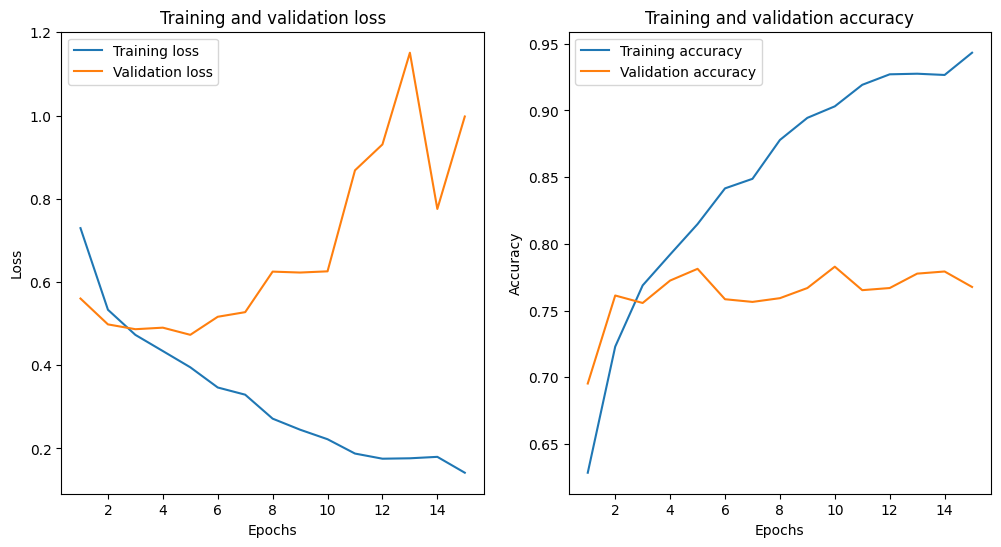

In [20]:
# Plot history
from math import ceil

def plot_history(params: list[str], val=True):
  num_rows = ceil(len(params)/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 6*num_rows))
  for i in range(len(params)):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    s.set_xlabel('Epochs')
    s.set_ylabel(par.capitalize())
    if val:
      s.plot(epochs, history.history[f'val_{par}'], label=f'Validation {par}')
      s.set_title(f'Training and validation {par}')
    else:
      s.set_title(f'Training {par}')
    s.legend()

plot_history(['loss', 'accuracy'])